<h1>AIKoGAM: An AI-driven Knowledge Graph of the Antiquities market: toward automatised methods to identify illicit trafficking networks</h1>
<p>This notebook enables to replicate the methods described in: Giovanelli, R.,Traviglia, A., 2023. <i>AIKoGAM: An AI-driven Knowledge Graph of the Antiquities market: toward automatised methods to identify illicit trafficking networks</i>.</p>

<h2>Web Harvesting</h2>

In [2]:
#import the libraries that will be used
import spacy
import lxml
import os
import json
import logging
import requests
import hashlib
from datetime import datetime
from src.utils.utils import *
from src.db.db_connection import *
from setup import config
from tqdm.notebook import tqdm
from bs4 import BeautifulSoup
from html import unescape
from typing import Dict, Any
from event_extraction import *
from kg_construction import *
now = datetime.now()
date_and_hour = datetime.now().strftime("%d%m%Y_%H%M")

<h3>Christie's WA</h3>
In the input, insert the first year from wich to start the collection, and the last year. Before 1998 there are no data.</br>
Chose if you want to store images. The images will be stored in a subfolder of a new "images" folder inside the project.</br>
The estimated time for storing data of a sale with around 80 objects and no images is 59 sec on a CPU.</br></p>

In [ ]:
start_year = int(input("Please, input the year from which to start scraping"))
end_year = int(input("Please, input the last year from which you want to scrape")) + 1
storingImage_christies = input("Do you want to store images? Y or N").lower()

if storingImage_christies == 'y':
    antiquities = collect_sales(start_year, end_year, log_file='data_collection.log', storeImage=True)
else:
    antiquities = collect_sales(start_year, end_year, log_file='data_collection.log', storeImage=False)

In [ ]:
antiquities[0] #run this cell if you want to have a look on the structure of the data

<h3>Sotheby's WA</h3>
<p>Chose if you want to store images. The images will be stored in a subfolder of a new "images" folder inside the project.</p>


In [ ]:
with open('auctionIds_sotheby.json','r',encoding='utf-8') as file:
    auctionIds_sotheby = json.load(file)
#storingImage_sothebys = input("Do you want to store images? Y or N").lower()
storingImage_sothebys = 'n'
if storingImage_sothebys == 'y':
    antiquities_sothebys = collect_sales_sothebys(auctionIds_sotheby, storeImage=True)
else:
    antiquities_sothebys = collect_sales_sothebys(auctionIds_sotheby, storeImage=False)

<h3>Phoenix Ancient Art's WA</h3>
<p>Chose if you want to store images. The images will be stored in a subfolder of a new "images" folder inside the project.</p>

In [ ]:
#storingImage_paa = input("Do you want to store images? Y or N").lower()
storingImage_paa = 'n'
if storingImage_paa == 'y':
    antiquities_paa = collectPAA(storeImage=True)
else:
    antiquities_paa = collectPAA(storeImage=False)

In [ ]:
antiquities_paa[0] #run this cell if you want to have a look on the structure of the data

<h2>Ontology mapping and Knowledge Graph database building</h2>

<h3>Ontology mapping</h3>
<p>The following cell will reload the datasets you stored from the previous cells and remap the datasets toward a single cleaned and postprocessed datasets, with only the relevant key-values pairs and a common taxonomy</p>

In [ ]:
import json
with open(r'christies_raw.json','r',encoding='utf-8') as f:
    christies_data = json.load(f)
with open(r'sothebys_raw.json','r',encoding='utf-8') as f2:
    sothebys_data = json.load(f2)
with open(r'paa_raw.json','r',encoding='utf-8') as f3:
    paa_data = json.load(f3)
    
start_time = time.time()
# Set up logging
logging.basicConfig(filename='error_log.log', level=logging.ERROR,format='%(asctime)s - %(levelname)s - %(message)s')
# Map Christie's data to the final keys
final_christies_data = remap_christies_data(christies_data)
# Map Sotheby's data to the final keys
final_sothebys_data = map_sothebys_data(sothebys_data)
# Map PAA's data to the final keys
final_paa_data = remap_paa_data(paa_data)
# Combine datasets into a single list
partial_output = final_sothebys_data + final_christies_data + final_paa_data
# Hash and Reorder json file
final_output = cleanSubdictionaries(partial_output)
db = hashAndClean(final_output)
end_time = time.time()
execution_time = end_time - start_time



In [29]:
print(f"The remapping and cleaning of the original datasets in a single one took {format_time(70.18606495857239)} to complete with:\n1269.95 it/s for Christie's\n2.98it/s for Sotheby's\n14961.61it/s for PAA")

The remapping and cleaning of the original datasets in a single one took 01:10 minutes to complete with:
1269.95 it/s for Christie's
2.98it/s for Sotheby's
14961.61it/s for PAA


The following cell will save in a .json file inside datasets folder the complete data

In [7]:
os.makedirs('datasets', exist_ok=True)
saveJson(db,'datasets/db.json')

The following cell will reload the completa data file

<h3>Knowledge Graph database building</h3>
The following cells will generate a Neo4j Knowledge Graph from the .json dataset, extracting events from the provenance statements as collected and refactoring them into separate entities such as actors, dates, locations.</br>
Before running the following cells make sure to follow the Neo4j installation guidelines.</br>
<p>
<b>Neo4j Installation and setup</b></br>
Install Neo4J Desktop from <a href='https://neo4j.com/deployment-center/'> here </a> chosing the right os.</br>
<img src="imgs/n4jdsk.png" width='630'> </br>
Follow along the guide from Neo4j documentation <a href='https://neo4j.com/docs/desktop-manual/current/'>here</a>.</br>
When you first database is created, as described <a href='https://neo4j.com/docs/desktop-manual/current/operations/create-dbms/'>here</a>, you will need to adjust the configuration inside the <a href='setup/config.py'>config.py</a> file under 'setup' folder in this project, changing the uri and the password according to your Neo4j Desktop configurations. The default localhost and username are the following, the password is set by you upon creating your first database instance.

</p>
<p>
neo4j = {</br>
    &nbsp;&nbsp;&nbsp;&nbsp;"uri":"bolt://localhost:7687",</br>
    &nbsp;&nbsp;&nbsp;&nbsp;"username": "neo4j",</br>
    &nbsp;&nbsp;&nbsp;&nbsp;"password": "admininstrator",</br>
    &nbsp;&nbsp;&nbsp;&nbsp;"encrypted": False</br>
}</br>
</p>
<p>When both Neo4j Desktop and the config file are set, click "Start" to start the Neo4j Database instance and then "Open".</p>
<p><img src='imgs/kgopen.png' width='630'></p>
<p></p>
<p><img src='imgs/kgstart.png' width='630'></p>
<p>This will open in a new window an empty database.</br>
<img src='imgs/newdb.png' width = '630'></br>
Making sure our database is <b>active</b>, we can procede and run the following cells.</p>

The following event_extraction.py analyses and splits each provenance statement found in the raw data into different <i>events</i>. Each event ideally contains an actor, a location, and a time-span indication.
For testing, we utilise the NER model 'en-core-web-md' from Spacy library. The output 'events/events.txt' will contain for each artwork the labeled entities found in each separated provenance event. </br>
The estimated time for extracting events from 39103 objects is 64 minutes on a CPU (nearly 10 objects/s)</br>

In [8]:
with open('datasets/db.json','r',encoding='utf-8') as d:
    data = json.load(d)
    print(len(data['events']),len(data['lots']))

529 30422


In [31]:
with open('events/events.txt','r',encoding='utf-8') as f:
    data = f.readlines()

In [110]:
relabel = []
count = 0

for x in data:
    c = json.loads(x)
    obj = c[next(iter(c))]

    if obj['events']:
        for o in obj['events']:
            ks = [key for event in o for key in event.keys()]

            if all(m == 'label' for m in ks):
                count += 1
                for elem in o:
                    text = elem['label'].lower()
                    for vi in obj['lotProvenance'].values():
                        if text in vi['text'].lower():
                            relabel.append(vi)
                            

                

print(count)

old_model = 'en_core_web_md'
nlp = spacy.load(old_model)
new_labels = []
for i in relabel[:120]:
    entities = {}
    
    text = i['text']
    print('Text',text)
    spacy_model = i['spacy_model']
    c = nlp(text)
    if c:
        print('Plain',c.ents, [x.label_ for x in c.ents])
    for ent in nlp(text).ents:
        # First, check SPACY_MAPPINGS for entity label mapping
        from setup.config import SPACY_MAPPINGS, ENTITIES_MAPPING
        for k, v in SPACY_MAPPINGS.items():
            if ent.label_ in v:
                ent.label_ = k
                break
    
        # Then, check ENTITIES_MAPPING for custom entity tag
        for tag, entity_list in ENTITIES_MAPPING.items():
            if ent.text in entity_list:
                ent.label_ = tag
                break
    
        label = ent.label_
        if label not in entities:
            entities[label] = [ent.text]
        else:
            entities[label].append(ent.text)
    entitie,old_model,nlp = utils.extract_named_entities(text, spacy_model, old_model, nlp)
    print('en',entities)
    print('new',entitie)

13228
Text Property from an Old Hong Kong Family Collection | 香港家族舊藏
Plain (an Old Hong Kong Family Collection |,) ['ORG']
en {'ORG': ['an Old Hong Kong Family Collection |']}
new {'GPE': ['香港']}
Text Property from an Old Hong Kong Family Collection | 香港家族舊藏
Plain (香港,) ['GPE']
en {'GPE': ['香港']}
new {'GPE': ['香港']}
Text Property from an Old Hong Kong Family Collection | 香港家族舊藏
Plain (香港,) ['GPE']
en {'GPE': ['香港']}
new {'GPE': ['香港']}
Text Property from an Old Hong Kong Family Collection | 香港家族舊藏
Plain (香港,) ['GPE']
en {'GPE': ['香港']}
new {'GPE': ['香港']}
Text Property from an Old Hong Kong Family Collection | 香港家族舊藏
Plain (香港,) ['GPE']
en {'GPE': ['香港']}
new {'GPE': ['香港']}
Text Property from an Old Hong Kong Family Collection | 香港家族舊藏
Plain (香港,) ['GPE']
en {'GPE': ['香港']}
new {'GPE': ['香港']}
Text Property from an Old Hong Kong Family Collection | 香港家族舊藏
Plain (香港,) ['GPE']
en {'GPE': ['香港']}
new {'GPE': ['香港']}
Text Property from an Old Hong Kong Family Collection | 香港家族舊藏
Plain (香港

In [82]:
print(relabel)

[{'text': 'Eskenazi Ltd, London, 1995, label  C1153.\xa0', 'detected_language': 'en', 'spacy_model': 'en_core_web_md'}, {'text': 'Eskenazi Ltd, London, 1995, label  C1153.\xa0', 'detected_language': 'en', 'spacy_model': 'en_core_web_md'}, {'text': 'Bluett & Sons Ltd, London,  173, label.', 'detected_language': 'sv', 'spacy_model': 'sv_core_news_sm'}, {'text': 'Bluett & Sons Ltd, London,  173, label.', 'detected_language': 'sv', 'spacy_model': 'sv_core_news_sm'}, {'text': 'Collection of Sir William\xa0Cornelius\xa0Van Horne, president of the Canadian Pacific Railway, label.', 'detected_language': 'en', 'spacy_model': 'en_core_web_md'}, {'text': 'Joseph V. Vizcarra Collection,  90, bearing label.\r\nSotheby Parke Bernet, Inc. New York, 12-14 April 1984, lot\xa0431', 'detected_language': 'en', 'spacy_model': 'en_core_web_md'}, {'text': 'Hodgkin Collection, bearing label', 'detected_language': 'de', 'spacy_model': 'de_core_news_sm'}, {'text': 'Joseph V. Vizcarra Collection,  90, bearing la

In [9]:
from batch_detector import *
__name__ == "__main__"
start_time = time.time()
if __name__ == '__main__':
    main()
end_time = time.time()
execution_time = end_time-start_time


Processing Batches:   0%|          | 0/609 [00:00<?, ?it/s]

197


  0%|          | 0/50 [00:00<?, ?it/s]

197


  0%|          | 0/50 [00:00<?, ?it/s]

198


  0%|          | 0/50 [00:00<?, ?it/s]

199


  0%|          | 0/50 [00:00<?, ?it/s]

200


  0%|          | 0/50 [00:00<?, ?it/s]

201


  0%|          | 0/50 [00:00<?, ?it/s]

202


  0%|          | 0/50 [00:00<?, ?it/s]

203


  0%|          | 0/50 [00:00<?, ?it/s]

204


  0%|          | 0/50 [00:00<?, ?it/s]

205


  0%|          | 0/50 [00:00<?, ?it/s]

206


  0%|          | 0/50 [00:00<?, ?it/s]

207


  0%|          | 0/50 [00:00<?, ?it/s]

208


  0%|          | 0/50 [00:00<?, ?it/s]

209


  0%|          | 0/50 [00:00<?, ?it/s]

210


  0%|          | 0/50 [00:00<?, ?it/s]

211


  0%|          | 0/50 [00:00<?, ?it/s]

212


  0%|          | 0/50 [00:00<?, ?it/s]

213


  0%|          | 0/50 [00:00<?, ?it/s]

214


  0%|          | 0/50 [00:00<?, ?it/s]

215


  0%|          | 0/50 [00:00<?, ?it/s]

216


  0%|          | 0/50 [00:00<?, ?it/s]

217


  0%|          | 0/50 [00:00<?, ?it/s]

218


  0%|          | 0/50 [00:00<?, ?it/s]

219


  0%|          | 0/50 [00:00<?, ?it/s]

220


  0%|          | 0/50 [00:00<?, ?it/s]

221


  0%|          | 0/50 [00:00<?, ?it/s]

222


  0%|          | 0/50 [00:00<?, ?it/s]

223


  0%|          | 0/50 [00:00<?, ?it/s]

224


  0%|          | 0/50 [00:00<?, ?it/s]

225


  0%|          | 0/50 [00:00<?, ?it/s]

226


  0%|          | 0/50 [00:00<?, ?it/s]

227


  0%|          | 0/50 [00:00<?, ?it/s]

228


  0%|          | 0/50 [00:00<?, ?it/s]

229


  0%|          | 0/50 [00:00<?, ?it/s]

230


  0%|          | 0/50 [00:00<?, ?it/s]

231


  0%|          | 0/50 [00:00<?, ?it/s]

232


  0%|          | 0/50 [00:00<?, ?it/s]

233


  0%|          | 0/50 [00:00<?, ?it/s]

234


  0%|          | 0/50 [00:00<?, ?it/s]

235


  0%|          | 0/50 [00:00<?, ?it/s]

236


  0%|          | 0/50 [00:00<?, ?it/s]

237


  0%|          | 0/50 [00:00<?, ?it/s]

238


  0%|          | 0/50 [00:00<?, ?it/s]

239


  0%|          | 0/50 [00:00<?, ?it/s]

240


  0%|          | 0/50 [00:00<?, ?it/s]

241


  0%|          | 0/50 [00:00<?, ?it/s]

242


  0%|          | 0/50 [00:00<?, ?it/s]

243


  0%|          | 0/50 [00:00<?, ?it/s]

244


  0%|          | 0/50 [00:00<?, ?it/s]

245


  0%|          | 0/50 [00:00<?, ?it/s]

246


  0%|          | 0/50 [00:00<?, ?it/s]

247


  0%|          | 0/50 [00:00<?, ?it/s]

248


  0%|          | 0/50 [00:00<?, ?it/s]

249


  0%|          | 0/50 [00:00<?, ?it/s]

250


  0%|          | 0/50 [00:00<?, ?it/s]

251


  0%|          | 0/50 [00:00<?, ?it/s]

252


  0%|          | 0/50 [00:00<?, ?it/s]

253


  0%|          | 0/50 [00:00<?, ?it/s]

254


  0%|          | 0/50 [00:00<?, ?it/s]

255


  0%|          | 0/50 [00:00<?, ?it/s]

256


  0%|          | 0/50 [00:00<?, ?it/s]

257


  0%|          | 0/50 [00:00<?, ?it/s]

258


  0%|          | 0/50 [00:00<?, ?it/s]

259


  0%|          | 0/50 [00:00<?, ?it/s]

260


  0%|          | 0/50 [00:00<?, ?it/s]

261


  0%|          | 0/50 [00:00<?, ?it/s]

262


  0%|          | 0/50 [00:00<?, ?it/s]

263


  0%|          | 0/50 [00:00<?, ?it/s]

264


  0%|          | 0/50 [00:00<?, ?it/s]

265


  0%|          | 0/50 [00:00<?, ?it/s]

266


  0%|          | 0/50 [00:00<?, ?it/s]

267


  0%|          | 0/50 [00:00<?, ?it/s]

268


  0%|          | 0/50 [00:00<?, ?it/s]

269


  0%|          | 0/50 [00:00<?, ?it/s]

270


  0%|          | 0/50 [00:00<?, ?it/s]

271


  0%|          | 0/50 [00:00<?, ?it/s]

272


  0%|          | 0/50 [00:00<?, ?it/s]

273


  0%|          | 0/50 [00:00<?, ?it/s]

274


  0%|          | 0/50 [00:00<?, ?it/s]

275


  0%|          | 0/50 [00:00<?, ?it/s]

276


  0%|          | 0/50 [00:00<?, ?it/s]

277


  0%|          | 0/50 [00:00<?, ?it/s]

278


  0%|          | 0/50 [00:00<?, ?it/s]

279


  0%|          | 0/50 [00:00<?, ?it/s]

280


  0%|          | 0/50 [00:00<?, ?it/s]

281


  0%|          | 0/50 [00:00<?, ?it/s]

282


  0%|          | 0/50 [00:00<?, ?it/s]

283


  0%|          | 0/50 [00:00<?, ?it/s]

284


  0%|          | 0/50 [00:00<?, ?it/s]

285


  0%|          | 0/50 [00:00<?, ?it/s]

286


  0%|          | 0/50 [00:00<?, ?it/s]

287


  0%|          | 0/50 [00:00<?, ?it/s]

288


  0%|          | 0/50 [00:00<?, ?it/s]

289


  0%|          | 0/50 [00:00<?, ?it/s]

290


  0%|          | 0/50 [00:00<?, ?it/s]

291


  0%|          | 0/50 [00:00<?, ?it/s]

292


  0%|          | 0/50 [00:00<?, ?it/s]

293


  0%|          | 0/50 [00:00<?, ?it/s]

294


  0%|          | 0/50 [00:00<?, ?it/s]

295


  0%|          | 0/50 [00:00<?, ?it/s]

296


  0%|          | 0/50 [00:00<?, ?it/s]

297


  0%|          | 0/50 [00:00<?, ?it/s]

298


  0%|          | 0/50 [00:00<?, ?it/s]

299


  0%|          | 0/50 [00:00<?, ?it/s]

300


  0%|          | 0/50 [00:00<?, ?it/s]

301


  0%|          | 0/50 [00:00<?, ?it/s]

302


  0%|          | 0/50 [00:00<?, ?it/s]

303


  0%|          | 0/50 [00:00<?, ?it/s]

304


  0%|          | 0/50 [00:00<?, ?it/s]

305


  0%|          | 0/50 [00:00<?, ?it/s]

306


  0%|          | 0/50 [00:00<?, ?it/s]

307


  0%|          | 0/50 [00:00<?, ?it/s]

308


  0%|          | 0/50 [00:00<?, ?it/s]

309


  0%|          | 0/50 [00:00<?, ?it/s]

310


  0%|          | 0/50 [00:00<?, ?it/s]

311


  0%|          | 0/50 [00:00<?, ?it/s]

312


  0%|          | 0/50 [00:00<?, ?it/s]

313


  0%|          | 0/50 [00:00<?, ?it/s]

314


  0%|          | 0/50 [00:00<?, ?it/s]

315


  0%|          | 0/50 [00:00<?, ?it/s]

316


  0%|          | 0/50 [00:00<?, ?it/s]

317


  0%|          | 0/50 [00:00<?, ?it/s]

318


  0%|          | 0/50 [00:00<?, ?it/s]

319


  0%|          | 0/50 [00:00<?, ?it/s]

320


  0%|          | 0/50 [00:00<?, ?it/s]

321


  0%|          | 0/50 [00:00<?, ?it/s]

322


  0%|          | 0/50 [00:00<?, ?it/s]

323


  0%|          | 0/50 [00:00<?, ?it/s]

324


  0%|          | 0/50 [00:00<?, ?it/s]

325


  0%|          | 0/50 [00:00<?, ?it/s]

326


  0%|          | 0/50 [00:00<?, ?it/s]

327


  0%|          | 0/50 [00:00<?, ?it/s]

328


  0%|          | 0/50 [00:00<?, ?it/s]

329


  0%|          | 0/50 [00:00<?, ?it/s]

330


  0%|          | 0/50 [00:00<?, ?it/s]

331


  0%|          | 0/50 [00:00<?, ?it/s]

332


  0%|          | 0/50 [00:00<?, ?it/s]

333


  0%|          | 0/50 [00:00<?, ?it/s]

334


  0%|          | 0/50 [00:00<?, ?it/s]

335


  0%|          | 0/50 [00:00<?, ?it/s]

336


  0%|          | 0/50 [00:00<?, ?it/s]

337


  0%|          | 0/50 [00:00<?, ?it/s]

338


  0%|          | 0/50 [00:00<?, ?it/s]

339


  0%|          | 0/50 [00:00<?, ?it/s]

340


  0%|          | 0/50 [00:00<?, ?it/s]

341


  0%|          | 0/50 [00:00<?, ?it/s]

342


  0%|          | 0/50 [00:00<?, ?it/s]

343


  0%|          | 0/50 [00:00<?, ?it/s]

344


  0%|          | 0/50 [00:00<?, ?it/s]

345


  0%|          | 0/50 [00:00<?, ?it/s]

346


  0%|          | 0/50 [00:00<?, ?it/s]

347


  0%|          | 0/50 [00:00<?, ?it/s]

348


  0%|          | 0/50 [00:00<?, ?it/s]

349


  0%|          | 0/50 [00:00<?, ?it/s]

350


  0%|          | 0/50 [00:00<?, ?it/s]

351


  0%|          | 0/50 [00:00<?, ?it/s]

352


  0%|          | 0/50 [00:00<?, ?it/s]

353


  0%|          | 0/50 [00:00<?, ?it/s]

354


  0%|          | 0/50 [00:00<?, ?it/s]

355


  0%|          | 0/50 [00:00<?, ?it/s]

356


  0%|          | 0/50 [00:00<?, ?it/s]

357


  0%|          | 0/50 [00:00<?, ?it/s]

358


  0%|          | 0/50 [00:00<?, ?it/s]

359


  0%|          | 0/50 [00:00<?, ?it/s]

360


  0%|          | 0/50 [00:00<?, ?it/s]

361


  0%|          | 0/50 [00:00<?, ?it/s]

362


  0%|          | 0/50 [00:00<?, ?it/s]

363


  0%|          | 0/50 [00:00<?, ?it/s]

364


  0%|          | 0/50 [00:00<?, ?it/s]

365


  0%|          | 0/50 [00:00<?, ?it/s]

366


  0%|          | 0/50 [00:00<?, ?it/s]

367


  0%|          | 0/50 [00:00<?, ?it/s]

368


  0%|          | 0/50 [00:00<?, ?it/s]

369


  0%|          | 0/50 [00:00<?, ?it/s]

370


  0%|          | 0/50 [00:00<?, ?it/s]

371


  0%|          | 0/50 [00:00<?, ?it/s]

372


  0%|          | 0/50 [00:00<?, ?it/s]

373


  0%|          | 0/50 [00:00<?, ?it/s]

374


  0%|          | 0/50 [00:00<?, ?it/s]

375


  0%|          | 0/50 [00:00<?, ?it/s]

376


  0%|          | 0/50 [00:00<?, ?it/s]

377


  0%|          | 0/50 [00:00<?, ?it/s]

378


  0%|          | 0/50 [00:00<?, ?it/s]

379


  0%|          | 0/50 [00:00<?, ?it/s]

380


  0%|          | 0/50 [00:00<?, ?it/s]

381


  0%|          | 0/50 [00:00<?, ?it/s]

382


  0%|          | 0/50 [00:00<?, ?it/s]

383


  0%|          | 0/50 [00:00<?, ?it/s]

384


  0%|          | 0/50 [00:00<?, ?it/s]

385


  0%|          | 0/50 [00:00<?, ?it/s]

386


  0%|          | 0/50 [00:00<?, ?it/s]

387


  0%|          | 0/50 [00:00<?, ?it/s]

388


  0%|          | 0/50 [00:00<?, ?it/s]

389


  0%|          | 0/50 [00:00<?, ?it/s]

390


  0%|          | 0/50 [00:00<?, ?it/s]

391


  0%|          | 0/50 [00:00<?, ?it/s]

392


  0%|          | 0/50 [00:00<?, ?it/s]

393


  0%|          | 0/50 [00:00<?, ?it/s]

394


  0%|          | 0/50 [00:00<?, ?it/s]

395


  0%|          | 0/50 [00:00<?, ?it/s]

396


  0%|          | 0/50 [00:00<?, ?it/s]

397


  0%|          | 0/50 [00:00<?, ?it/s]

398


  0%|          | 0/50 [00:00<?, ?it/s]

399


  0%|          | 0/50 [00:00<?, ?it/s]

400


  0%|          | 0/50 [00:00<?, ?it/s]

401


  0%|          | 0/50 [00:00<?, ?it/s]

402


  0%|          | 0/50 [00:00<?, ?it/s]

403


  0%|          | 0/50 [00:00<?, ?it/s]

404


  0%|          | 0/50 [00:00<?, ?it/s]

405


  0%|          | 0/50 [00:00<?, ?it/s]

406


  0%|          | 0/50 [00:00<?, ?it/s]

407


  0%|          | 0/50 [00:00<?, ?it/s]

408


  0%|          | 0/50 [00:00<?, ?it/s]

409


  0%|          | 0/50 [00:00<?, ?it/s]

410


  0%|          | 0/50 [00:00<?, ?it/s]

411


  0%|          | 0/50 [00:00<?, ?it/s]

412


  0%|          | 0/50 [00:00<?, ?it/s]

413


  0%|          | 0/50 [00:00<?, ?it/s]

414


  0%|          | 0/50 [00:00<?, ?it/s]

415


  0%|          | 0/50 [00:00<?, ?it/s]

416


  0%|          | 0/50 [00:00<?, ?it/s]

417


  0%|          | 0/50 [00:00<?, ?it/s]

418


  0%|          | 0/50 [00:00<?, ?it/s]

419


  0%|          | 0/50 [00:00<?, ?it/s]

420


  0%|          | 0/50 [00:00<?, ?it/s]

421


  0%|          | 0/50 [00:00<?, ?it/s]

422


  0%|          | 0/50 [00:00<?, ?it/s]

423


  0%|          | 0/50 [00:00<?, ?it/s]

424


  0%|          | 0/50 [00:00<?, ?it/s]

425


  0%|          | 0/50 [00:00<?, ?it/s]

426


  0%|          | 0/50 [00:00<?, ?it/s]

427


  0%|          | 0/50 [00:00<?, ?it/s]

428


  0%|          | 0/50 [00:00<?, ?it/s]

429


  0%|          | 0/50 [00:00<?, ?it/s]

430


  0%|          | 0/50 [00:00<?, ?it/s]

431


  0%|          | 0/50 [00:00<?, ?it/s]

432


  0%|          | 0/50 [00:00<?, ?it/s]

433


  0%|          | 0/50 [00:00<?, ?it/s]

434


  0%|          | 0/50 [00:00<?, ?it/s]

435


  0%|          | 0/50 [00:00<?, ?it/s]

436


  0%|          | 0/50 [00:00<?, ?it/s]

437


  0%|          | 0/50 [00:00<?, ?it/s]

438


  0%|          | 0/50 [00:00<?, ?it/s]

439


  0%|          | 0/50 [00:00<?, ?it/s]

440


  0%|          | 0/50 [00:00<?, ?it/s]

441


  0%|          | 0/50 [00:00<?, ?it/s]

442


  0%|          | 0/50 [00:00<?, ?it/s]

443


  0%|          | 0/50 [00:00<?, ?it/s]

444


  0%|          | 0/50 [00:00<?, ?it/s]

445


  0%|          | 0/50 [00:00<?, ?it/s]

446


  0%|          | 0/50 [00:00<?, ?it/s]

447


  0%|          | 0/50 [00:00<?, ?it/s]

448


  0%|          | 0/50 [00:00<?, ?it/s]

449


  0%|          | 0/50 [00:00<?, ?it/s]

450


  0%|          | 0/50 [00:00<?, ?it/s]

451


  0%|          | 0/50 [00:00<?, ?it/s]

452


  0%|          | 0/50 [00:00<?, ?it/s]

453


  0%|          | 0/50 [00:00<?, ?it/s]

454


  0%|          | 0/50 [00:00<?, ?it/s]

455


  0%|          | 0/50 [00:00<?, ?it/s]

456


  0%|          | 0/50 [00:00<?, ?it/s]

457


  0%|          | 0/50 [00:00<?, ?it/s]

458


  0%|          | 0/50 [00:00<?, ?it/s]

459


  0%|          | 0/50 [00:00<?, ?it/s]

460


  0%|          | 0/50 [00:00<?, ?it/s]

461


  0%|          | 0/50 [00:00<?, ?it/s]

462


  0%|          | 0/50 [00:00<?, ?it/s]

463


  0%|          | 0/50 [00:00<?, ?it/s]

464


  0%|          | 0/50 [00:00<?, ?it/s]

465


  0%|          | 0/50 [00:00<?, ?it/s]

466


  0%|          | 0/50 [00:00<?, ?it/s]

467


  0%|          | 0/50 [00:00<?, ?it/s]

468


  0%|          | 0/50 [00:00<?, ?it/s]

469


  0%|          | 0/50 [00:00<?, ?it/s]

470


  0%|          | 0/50 [00:00<?, ?it/s]

471


  0%|          | 0/50 [00:00<?, ?it/s]

472


  0%|          | 0/50 [00:00<?, ?it/s]

473


  0%|          | 0/50 [00:00<?, ?it/s]

474


  0%|          | 0/50 [00:00<?, ?it/s]

475


  0%|          | 0/50 [00:00<?, ?it/s]

476


  0%|          | 0/50 [00:00<?, ?it/s]

477


  0%|          | 0/50 [00:00<?, ?it/s]

478


  0%|          | 0/50 [00:00<?, ?it/s]

479


  0%|          | 0/50 [00:00<?, ?it/s]

480


  0%|          | 0/50 [00:00<?, ?it/s]

481


  0%|          | 0/50 [00:00<?, ?it/s]

482


  0%|          | 0/50 [00:00<?, ?it/s]

483


  0%|          | 0/50 [00:00<?, ?it/s]

484


  0%|          | 0/50 [00:00<?, ?it/s]

485


  0%|          | 0/50 [00:00<?, ?it/s]

486


  0%|          | 0/50 [00:00<?, ?it/s]

487


  0%|          | 0/50 [00:00<?, ?it/s]

488


  0%|          | 0/50 [00:00<?, ?it/s]

489


  0%|          | 0/50 [00:00<?, ?it/s]

490


  0%|          | 0/50 [00:00<?, ?it/s]

491


  0%|          | 0/50 [00:00<?, ?it/s]

492


  0%|          | 0/50 [00:00<?, ?it/s]

493


  0%|          | 0/50 [00:00<?, ?it/s]

494


  0%|          | 0/50 [00:00<?, ?it/s]

495


  0%|          | 0/50 [00:00<?, ?it/s]

496


  0%|          | 0/50 [00:00<?, ?it/s]

497


  0%|          | 0/50 [00:00<?, ?it/s]

498


  0%|          | 0/50 [00:00<?, ?it/s]

499


  0%|          | 0/50 [00:00<?, ?it/s]

500


  0%|          | 0/50 [00:00<?, ?it/s]

501


  0%|          | 0/50 [00:00<?, ?it/s]

502


  0%|          | 0/50 [00:00<?, ?it/s]

503


  0%|          | 0/50 [00:00<?, ?it/s]

504


  0%|          | 0/50 [00:00<?, ?it/s]

505


  0%|          | 0/50 [00:00<?, ?it/s]

506


  0%|          | 0/50 [00:00<?, ?it/s]

507


  0%|          | 0/50 [00:00<?, ?it/s]

508


  0%|          | 0/50 [00:00<?, ?it/s]

509


  0%|          | 0/50 [00:00<?, ?it/s]

510


  0%|          | 0/50 [00:00<?, ?it/s]

511


  0%|          | 0/50 [00:00<?, ?it/s]

512


  0%|          | 0/50 [00:00<?, ?it/s]

513


  0%|          | 0/50 [00:00<?, ?it/s]

514


  0%|          | 0/50 [00:00<?, ?it/s]

515


  0%|          | 0/50 [00:00<?, ?it/s]

516


  0%|          | 0/50 [00:00<?, ?it/s]

517


  0%|          | 0/50 [00:00<?, ?it/s]

518


  0%|          | 0/50 [00:00<?, ?it/s]

519


  0%|          | 0/50 [00:00<?, ?it/s]

520


  0%|          | 0/50 [00:00<?, ?it/s]

521


  0%|          | 0/50 [00:00<?, ?it/s]

522


  0%|          | 0/50 [00:00<?, ?it/s]

523


  0%|          | 0/50 [00:00<?, ?it/s]

524


  0%|          | 0/50 [00:00<?, ?it/s]

525


  0%|          | 0/50 [00:00<?, ?it/s]

526


  0%|          | 0/50 [00:00<?, ?it/s]

527


  0%|          | 0/50 [00:00<?, ?it/s]

528


  0%|          | 0/50 [00:00<?, ?it/s]

529


  0%|          | 0/50 [00:00<?, ?it/s]

530


  0%|          | 0/50 [00:00<?, ?it/s]

531


  0%|          | 0/50 [00:00<?, ?it/s]

532


  0%|          | 0/50 [00:00<?, ?it/s]

533


  0%|          | 0/50 [00:00<?, ?it/s]

534


  0%|          | 0/50 [00:00<?, ?it/s]

535


  0%|          | 0/50 [00:00<?, ?it/s]

536


  0%|          | 0/50 [00:00<?, ?it/s]

537


  0%|          | 0/50 [00:00<?, ?it/s]

538


  0%|          | 0/50 [00:00<?, ?it/s]

539


  0%|          | 0/50 [00:00<?, ?it/s]

540


  0%|          | 0/50 [00:00<?, ?it/s]

541


  0%|          | 0/50 [00:00<?, ?it/s]

542


  0%|          | 0/50 [00:00<?, ?it/s]

543


  0%|          | 0/50 [00:00<?, ?it/s]

544


  0%|          | 0/50 [00:00<?, ?it/s]

545


  0%|          | 0/50 [00:00<?, ?it/s]

546


  0%|          | 0/50 [00:00<?, ?it/s]

547


  0%|          | 0/50 [00:00<?, ?it/s]

548


  0%|          | 0/50 [00:00<?, ?it/s]

549


  0%|          | 0/50 [00:00<?, ?it/s]

550


  0%|          | 0/50 [00:00<?, ?it/s]

551


  0%|          | 0/50 [00:00<?, ?it/s]

552


  0%|          | 0/50 [00:00<?, ?it/s]

553


  0%|          | 0/50 [00:00<?, ?it/s]

554


  0%|          | 0/50 [00:00<?, ?it/s]

555


  0%|          | 0/50 [00:00<?, ?it/s]

556


  0%|          | 0/50 [00:00<?, ?it/s]

557


  0%|          | 0/50 [00:00<?, ?it/s]

558


  0%|          | 0/50 [00:00<?, ?it/s]

559


  0%|          | 0/50 [00:00<?, ?it/s]

560


  0%|          | 0/50 [00:00<?, ?it/s]

561


  0%|          | 0/50 [00:00<?, ?it/s]

562


  0%|          | 0/50 [00:00<?, ?it/s]

563


  0%|          | 0/50 [00:00<?, ?it/s]

564


  0%|          | 0/50 [00:00<?, ?it/s]

565


  0%|          | 0/50 [00:00<?, ?it/s]

566


  0%|          | 0/50 [00:00<?, ?it/s]

567


  0%|          | 0/50 [00:00<?, ?it/s]

568


  0%|          | 0/50 [00:00<?, ?it/s]

569


  0%|          | 0/50 [00:00<?, ?it/s]

570


  0%|          | 0/50 [00:00<?, ?it/s]

571


  0%|          | 0/50 [00:00<?, ?it/s]

572


  0%|          | 0/50 [00:00<?, ?it/s]

573


  0%|          | 0/50 [00:00<?, ?it/s]

574


  0%|          | 0/50 [00:00<?, ?it/s]

575


  0%|          | 0/50 [00:00<?, ?it/s]

576


  0%|          | 0/50 [00:00<?, ?it/s]

577


  0%|          | 0/50 [00:00<?, ?it/s]

578


  0%|          | 0/50 [00:00<?, ?it/s]

579


  0%|          | 0/50 [00:00<?, ?it/s]

580


  0%|          | 0/50 [00:00<?, ?it/s]

581


  0%|          | 0/50 [00:00<?, ?it/s]

582


  0%|          | 0/50 [00:00<?, ?it/s]

583


  0%|          | 0/50 [00:00<?, ?it/s]

584


  0%|          | 0/50 [00:00<?, ?it/s]

585


  0%|          | 0/50 [00:00<?, ?it/s]

586


  0%|          | 0/50 [00:00<?, ?it/s]

587


  0%|          | 0/50 [00:00<?, ?it/s]

588


  0%|          | 0/50 [00:00<?, ?it/s]

589


  0%|          | 0/50 [00:00<?, ?it/s]

590


  0%|          | 0/50 [00:00<?, ?it/s]

591


  0%|          | 0/50 [00:00<?, ?it/s]

592


  0%|          | 0/50 [00:00<?, ?it/s]

593


  0%|          | 0/50 [00:00<?, ?it/s]

594


  0%|          | 0/50 [00:00<?, ?it/s]

595


  0%|          | 0/50 [00:00<?, ?it/s]

596


  0%|          | 0/50 [00:00<?, ?it/s]

597


  0%|          | 0/50 [00:00<?, ?it/s]

598


  0%|          | 0/50 [00:00<?, ?it/s]

599


  0%|          | 0/50 [00:00<?, ?it/s]

600


  0%|          | 0/50 [00:00<?, ?it/s]

601


  0%|          | 0/50 [00:00<?, ?it/s]

602


  0%|          | 0/50 [00:00<?, ?it/s]

603


  0%|          | 0/50 [00:00<?, ?it/s]

604


  0%|          | 0/50 [00:00<?, ?it/s]

605


  0%|          | 0/50 [00:00<?, ?it/s]

606


  0%|          | 0/50 [00:00<?, ?it/s]

607


  0%|          | 0/50 [00:00<?, ?it/s]

608


  0%|          | 0/22 [00:00<?, ?it/s]

Processing dictionaries:   0%|          | 0/609 [00:00<?, ?it/s]

Filename: C:\Users\rgiovanelli.IIT\PycharmProjects\AIKoGAM\batch_detector.py

Line #    Mem usage    Increment  Occurrences   Line Contents
    38   1473.7 MiB   1473.7 MiB           1   @profile
    39                                         def main():
    40                                             """
    41                                             The main function for processing a dataset, detecting languages, and creating batch files.
    42                                         
    43                                             This function reads a dataset, splits it into batches, and processes each batch using
    44                                             parallel processing. It then merges the processed batch files into a single dataset.
    45                                         
    46                                             Args:
    47                                                 None
    48                                         
    49        

In [27]:
print(f'The batch process to detect language for each provenance statement took {format_time(execution_time)}')

The batch process to detect language for each provenance statement took 14:14 minutes


In [11]:
print(f"Events: {len(data['events'])}")
print(f"Artworks: {len(data['lots'])}")
print(f"Sources: 3")
print(f"Total entries: {len(data['events'])+len(data['lots'])+3}")

Events: 529
Artworks: 30422
Sources: 3
Total entries: 30954


In [12]:
from setup.config import batch_size,num_processes, DATASET_FOLDER, RAW_DATASET, BATCH_FOLDER, PATTERN
with open(f"{DATASET_FOLDER}lang_db.json",'r',encoding='utf-8') as lang:
    data_lang = json.load(lang)

data['lots'] = data_lang['lots']

saveJson(data,f"{DATASET_FOLDER}final_db.json")

In [1]:
#import the libraries that will be used
import spacy
import lxml
import os
import json
import logging
import requests
import hashlib
from datetime import datetime
from src.utils.utils import *
from src.db.db_connection import *
from setup import config
from tqdm.notebook import tqdm
from bs4 import BeautifulSoup
from html import unescape
from typing import Dict, Any
from event_extraction import *
from kg_construction import *
now = datetime.now()
date_and_hour = datetime.now().strftime("%d%m%Y_%H%M")

In [ ]:
from tqdm.notebook import tqdm
from event_extraction import *
from datetime import datetime


start_time = time.time()

if __name__ == "__main__":  
    with open('datasets/final_db.json','r',encoding='utf-8') as f:
        file = json.load(f)
    
            
    
        
    annos=file
    annosk = list(annos.keys())
    annosv = list(annos.values())
    artworks = list(new_f['lots'].values())
     
    artwork_index = batch_extract_store_events(artworks, batch_size=20,annosk=annosk,annosv=annosv)
            
    print("Job done")        
end_time = time.time()
execution_time = end_time - start_time

In [ ]:
from tqdm.notebook import tqdm
from event_extraction import *
from datetime import datetime


start_time = time.time()

if __name__ == "__main__":  
    with open('datasets/final_db.json','r',encoding='utf-8') as f:
        file = json.load(f)
    new_f = {'events':'','lots':{}}
    count = 0
    for k,v in file['lots'].items():
        if count < 1:
            new_f['lots'][k] = v
            count += 5
    
            
    
        
    annos=new_f
    annosk = list(annos.keys())
    annosv = list(annos.values())
    artworks = list(new_f['lots'].values())
     
    artwork_index = batch_extract_store_events(artworks, batch_size=20,annosk=annosk,annosv=annosv)
            
    print("Job done")        
end_time = time.time()
execution_time = end_time - start_time

In [ ]:
print(f'The NAMED ENTITY RECOGNITION process and generation of events took {format_time(execution_time)}')

In [42]:
annosk

['events', 'lots']

In [41]:
with open('datasets/final_db.json','r',encoding='utf-8') as f:
    file = json.load(f)
new_f = {'events':'','lots':{}}
count = 0
for k,v in file['lots'].items():
    if count < 5:
        new_f['lots'][k] = v
        count += 1

        

    
annos=new_f
annosk = list(annos.keys())
annosv = list(annos.values())
artworks = list(new_f['lots'].values())

print(annosk,annosv)

annosk['301']

['events', 'lots'] ['', {'ac68067c0edb36efc6556baae15fdbaa58658c569489fee86fba97c60197b3f883803ef62ef69b55883b80beee338f8b8e46254534d2c7ec954897fa4d815c0b': {'lotId': 'dcc51b21-8228-4b91-a37c-03c73e300f17', 'lotNumber': '301', 'lotUrl': 'www.sothebys.com/en/buy/auction/2022/china-5000-years-10a-fine-pair-of-blue-and-white-trigram-bowls-marks', 'lotTitle': "A fine pair of blue and white 'trigram' bowls, Marks and period of Kangxi 清康熙 青花八卦海水紋盌一對 《大清康熙年製》款", 'lotSubtitle': '', 'lotOther': '', 'lotLastOwner': 'Property from an Old Hong Kong Family Collection | 香港家族舊藏', 'lotDescription': "<p>Property from an Old Hong Kong Family Collection</p><p>A&nbsp;fine pair of blue and white 'trigram' bowls,</p><p>Marks and period of Kangxi</p><p>香港家族舊藏</p><p>清康熙 青花八卦海水紋盌一對</p><p>《大清康熙年製》款</p><p><br></p><p>wood stands</p><p>each d. 12.2 cm</p>", 'lotImage': 'https://sothebys-md.brightspotcdn.com/webnative/images/08/f5/d686177940ed8bdd2f7678d10ae1/hk1280-cdcy7-t3-02.jpg', 'lotImageLocalPath': '', 'lotEs

TypeError: list indices must be integers or slices, not str

In [36]:
old_model = 'en_core_web_md'
spacy_model = old_model
nlp = spacy.load('en_core_web_md')
iteration_counter = 0
def clean_provenance(prov):
    """
    Preprocess provenance text.

    Parameters
    ----------
    prov : str
        Provenance text.

    Returns
    -------
    prov : str
        Preprocessed provenance text.
    """ 
    # Remove the parts of the provenance that are inside brackets (to facilitate extracting events)
    prov = re.sub("\s[\[\(].*?[\)\]]", "", prov)
    
    # This is to avoid the splitting of provenance with such kind of dots 
    prov = re.sub("Dr\.|Mr\.|Ms\.|Mrs\.|Prof\.|St\.|Rev\.|acc\.|vol\.|no\.|pl\.|inv\.", "", prov, flags=re.IGNORECASE)
    
    # The ":" and ";" act as event separator such as the "."
    prov = prov.replace(':', '.')
    prov = prov.replace(';', '.')
    
    # Cleaning
    prov = prov.replace('. ,', ',')
    prov = prov.replace('. ;', ',')    
    prov = prov.replace('.,', ',')
    
    prov = prov.replace('_', '')
    
    prov = prov.replace('<em>', '')
    
        
    return prov

def extract_events_dot(text):
    """
    Extract events from a paragraph based on full stops.
    
    Parameters
    ----------
    text : str
        A paragraph.
    
    Returns
    -------
    events : list
        List of events found.
    """
    events = re.findall('[^\d,;\(\)\'\"\’\&\\-:/|]+', text)
    events = [s.strip() for s in events]
    events = [s.rstrip('.') for s in events]
    return events
    
for json_object in artworks:
    prov = json_object.get('lotProvenance')
    print(prov,'\n')
    events_of_artworks = []
    try:
        if prov:
            for k,v in prov.items():
                if v is None:
                    pass
                elif k == 'provenance_0':
                    pass
                elif isinstance(v,dict):
                    prov_text = clean_provenance(v['text'])
                    print(prov_text)
                    spacy_model = v['spacy_model']
                    entities,old_model,nlp = utils.extract_named_entities(prov_text,spacy_model,old_model,nlp)
                    print(entities)
                    for i, entity_ls in enumerate(entities.values()):
                        print(i,entity_ls)
                        if(list(entities.keys())[i] != 'DATE'):
                            for e in entity_ls:
                                print(e)
                                print(prov_text)
                                nept = prov_text
                                nept = nept.replace(e,utils.remove_dots(e))
                                print(nept)
                    events = extract_events_dot(nept)
                    print(events)
                    artwork_events = []

                    for event in events:
                        ev_data = {}
                        ev_data['label'] = event.strip()
                        print(ev_data)
                        for entity_type in entities.keys():
                            ev_data[entity_type] = entities[entity_type]
                            print(ev_data,entities)
                        artwork_events.append(ev_data)
                        print('\n',artwork_events)
                    for event in artwork_events:
                        new_elems = []
                        label_value = None
                        for k,v in event.items():
                            print('\n\n\n\n',k,v)
                            if k == 'label':
                                label_value = v
                                new_elems.append((k,v))
                            elif isinstance(v,str):
                                if v in annosk:
                                    idx = annosk.index(v)
                                    print(idx)
                                    new_elems.append((annosv[idx],v))
                                    print(new_elems)
                                

    except Exception as e:
        print('error',e)

{'provenance_1': {'text': 'Property from an Old Hong Kong Family Collection | 香港家族舊藏', 'detected_language': 'zh', 'spacy_model': 'zh_core_web_sm'}, 'provenance_2': {'text': "Sotheby's Hong Kong 25 October 2022 lot 301", 'detected_language': 'en', 'spacy_model': 'en_core_web_md'}} 

Property from an Old Hong Kong Family Collection | 香港家族舊藏
{'GPE': ['香港']}
0 ['香港']
香港
Property from an Old Hong Kong Family Collection | 香港家族舊藏
Property from an Old Hong Kong Family Collection | 香港家族舊藏
['Property from an Old Hong Kong Family Collection', '香港家族舊藏']
{'label': 'Property from an Old Hong Kong Family Collection'}
{'label': 'Property from an Old Hong Kong Family Collection', 'GPE': ['香港']} {'GPE': ['香港']}

 [{'label': 'Property from an Old Hong Kong Family Collection', 'GPE': ['香港']}]
{'label': '香港家族舊藏'}
{'label': '香港家族舊藏', 'GPE': ['香港']} {'GPE': ['香港']}

 [{'label': 'Property from an Old Hong Kong Family Collection', 'GPE': ['香港']}, {'label': '香港家族舊藏', 'GPE': ['香港']}]




 label Property from an 

In [26]:
ev_data

{'label': 'lot',
 'ORG': ["Sotheby's Hong Kong"],
 'DATE': ['25 October 2022'],
 'NUMBER': ['301']}

In [2]:
#check for duplicates based on lotHash
data = duplicatesCheck("events/events.txt")

Length of data: 86883
Length of unique_entries: 30422
Duplicates removed: 56461


The following code will populate the Neo4j database with the original nodes of artworks and events connected to the corresponding artworks through a (a:artwork)-[r:PARTICIPATED_TO_EVENT]->(b:event) relationship.</br>
In this way, each event involving a specific object is automatically linked to the respective entities represented within it.</br>
Autonomous CYPHER queries refactor the events according to the ontology schema: the event node remains central, receiving relationships from the artworks and projecting or receiving new relationships to other entities automatically generated by Spacy and refactored based on our ontology.</br>
The estimated time for building and refactoring the Neo4j KG Database is  minutes on a CPU.</br>

In [4]:
__name__ = "__main__"
import kg_construction
from kg_construction import *
import time
start_time = time.time()
if __name__ == "__main__":
    main()
end_time = time.time()
execution_time = end_time - start_time


  0%|          | 0/30422 [00:00<?, ?it/s]

starting extraction of new entities from events
merging double rels


In [24]:
print(f'The Knwoledge Graph creation took {format_time(end_time - start_time)}')

The Knwoledge Graph creation took 1:54:43 hours


<h2>Preliminary Results</h2>

In [58]:
def generalQuery(query):
    uri = "bolt://localhost:7687"
    username = "neo4j"
    password = "administrator"

    with GraphDatabase.driver(uri, auth=(username, password), encrypted=False) as driver:
        with driver.session() as session:
            result = session.run(query)
            records = list(result)

    print(query)
    return records


In [36]:
import networkx as nx
from pyvis.network import Network
import matplotlib.pyplot as plt
import pickle
import os
from tqdm.notebook import tqdm

<h3>First Projection: from Knowledge Graph to bipartite Graph</h3>

With the following cell we connect to our Neo4j database and collect artwor, events and actors nodes with their relationsip.

In [ ]:
import networkx as nx
from pyvis.network import Network
import matplotlib.pyplot as plt
import pickle
import os
from tqdm.notebook import tqdm
import pickle
from unidecode import unidecode


query = "MATCH (n:artwork)-[r]-(e:event)-[r2]-(a:actor) RETURN *"
result = generalQuery(query)

G = nx.Graph()

for record in tqdm(result):
    artwork_node = record["n"]
    artwork_id = artwork_node['artwork_id']
    print(artwork_id)
    event_node = record["e"]
    event_id = event_node['event_id']
    actor_node = record["a"]
    actor_id = dict_hash(dict(actor_node))
    relationship_1 = record["r"]
    relationship_2 = record["r2"]

    # Add nodes and edges to the NetworkX graph
    G.add_node(artwork_id, label='artwork', properties=artwork_node._properties)    
    G.add_node(event_id, label="event", properties=event_node._properties)
    G.add_node(actor_id, label="actor", properties=actor_node._properties)
    G.nodes[actor_id]['actor_id'] = actor_id
    G.add_edge(artwork_id, event_id, label=relationship_1.type, direction='forward')
    G.add_edge(event_id, actor_id, label=relationship_2.type, direction='reverse')

print("Node count:", G.number_of_nodes())
print("Edge count:", G.number_of_edges())

os.makedirs('graphs', exist_ok=True)
# save graph object to file
pickle.dump(G, open('graphs/graph.pickle', 'wb'))

In [63]:
print("Node count:", G.number_of_nodes())
print("Edge count:", G.number_of_edges())

Node count: 97297
Edge count: 128992


In [64]:
# load graph object from file
G = pickle.load(open('graphs/graph.pickle', 'rb'))

In [107]:
def refactoring(string, graph):
    old_actors_nodes = set()
    
    # Identify actor nodes with 'Sotheby's' in their name
    for node in tqdm(subgraph.nodes(), desc=f"Identifying {string.capitalize()} nodes"):
        if graph.nodes[node]['label'] == 'actor':
            name = graph.nodes[node]['properties']['name']
            if string in name.lower():
                old_actors_nodes.add(node)
    
    # Create the super node and update relationships
    # Update relationships for super node
    if old_actors_nodes:
        for actor in tqdm(old_actors_nodes, desc=f'Updating relationships for {string.capitalize()}'):
            neighbors = list(graph.neighbors(actor))
            for neighbor in neighbors:
                edges = graph.edges(actor, neighbor)
                for edge in edges:
                    graph.add_edge(string.capitalize(), neighbor, attr_dict=edge[2])
        
        graph.add_edges_from(edges_to_add)
        graph.remove_nodes_from(nodes_to_remove)

    return graph

def newNodeId(subgraph):
    all_ids = {node for node in subgraph.nodes() if isinstance(node, int)}
    new_node_id = str(min(set(range(1, max(all_ids) + 2)) - all_ids))
    return new_node_id

from unidecode import unidecode

def normalize_name(name):
    return unidecode(name.lower())

def merge_nodes_with_name(graph, name):
    normalized_name = normalize_name(name)
    nodes_to_merge = [node for node in graph.nodes() if graph.nodes[node]['label'] == 'actor' and normalized_name in normalize_name(graph.nodes[node]['properties']['name']) and node != name]
    
    
    
    if nodes_to_merge:
        nodes_to_merge_names = [graph.nodes[node]['properties']['name'] for node in nodes_to_merge]
        print(nodes_to_merge_names)
        merged_node_id = name
        print(merged_node_id)
        graph.add_node(merged_node_id, label='actor', properties={'name': merged_node_id})
        
        for node in nodes_to_merge:
            neighbors = list(graph.neighbors(node))
            for neighbor in neighbors:
                if graph.nodes[neighbor]['label'] == 'artwork':
                    graph.add_edge(merged_node_id, neighbor, label='dealt_with', direction='forward')
            graph.remove_node(node)

    
    
    return graph

def normalize_name(name):
    """
    Normalize a name by converting it to lowercase and removing Unicode characters.
    
    Parameters:
    name (str): The input name to be normalized.
    
    Returns:
    str: The normalized name.
    """
    return unidecode(name.lower())

def generate_ngrams(string, n):
    """
    Generate n-grams of length n from a given string.
    
    Parameters:
    string (str): The input string from which n-grams will be generated.
    n (int): The length of each n-gram.
    
    Returns:
    list: A list of n-grams.
    """
    return [string[i:i + n] for i in range(len(string) - n + 1)]

def build_ngram_index(strings, n=3):
    """
    Build an n-gram index for a list of strings.
    Each n-gram maps to a list of strings containing that n-gram.
    
    Parameters:
    strings (list): List of strings to build the n-gram index from.
    n (int): The length of each n-gram.
    
    Returns:
    defaultdict: A defaultdict containing the n-gram index.
    """
    ngram_index = defaultdict(list)
    for string in strings:
        ngrams = generate_ngrams(string, n)
        for ngram in ngrams:
            ngram_index[ngram].append(string)
    return ngram_index

def exception_append(shorter_string, merges, ngram_index):
    """
    Append a string to the list of merges if it doesn't meet any exception criteria.
    Also, check if the string's n-grams match with any existing strings using the n-gram index.
    
    Parameters:
    shorter_string (str): The string to be added to the merges list.
    merges (list): The list of merged strings.
    ngram_index (defaultdict): The n-gram index built from build_ngram_index function.
    
    Returns:
    list: The updated merges list.
    """
    if shorter_string in merges or shorter_string.lower() in exceptionsin or shorter_string.lower() in exceptionsequals:
        return merges
    # Check if any of the n-grams of the new string are present in the n-gram index
    ngrams = generate_ngrams(shorter_string, 3)  # Using 3-grams for comparison
    for ngram in ngrams:
        if ngram in ngram_index:
            print(f"Similarity found for '{shorter_string}': {ngram_index[ngram]}")
            break
    merges.append(shorter_string)
    print(f"Added to merges: {shorter_string}")
    return merges

def find_similar_nodes(graph, merges, threshold=0.8):
    """
    Find nodes with similar names in the graph and update the list of merges accordingly.
    Also, utilize the n-gram index to identify similar strings.
    
    Parameters:
    graph (NetworkX Graph): The graph containing nodes to compare.
    merges (list): The list of merged strings.
    threshold (float, optional): The similarity threshold for node comparison.
    
    Returns:
    tuple: A tuple containing the list of similar nodes and the updated merges list.
    """
    similar_nodes = []
    ngram_index = build_ngram_index(merges)

    for node1 in tqdm(graph.nodes(), desc='Calculating similarity'):
        if graph.nodes[node1]['label'] == 'actor':
            name1 = graph.nodes[node1]['properties']['name']
            normalized_name1 = normalize_name(name1)

            for node2 in graph.nodes():
                if node1 != node2 and graph.nodes[node2]['label'] == 'actor':
                    name2 = graph.nodes[node2]['properties']['name']
                    normalized_name2 = normalize_name(name2)
                    

                    if normalized_name2 == normalized_name1:
                        shorter_string = normalized_name1 if len(normalized_name1) < len(normalized_name2) else normalized_name2
                        shorter_string = shorter_string.title()
                        merges = exception_append(shorter_string, merges, ngram_index)
                    else:
                        similarity = fuzz.ratio(normalized_name1, normalized_name2) / 100
                        if similarity >= threshold:
                            similar_nodes.append((node1, node2, similarity))
                            similarity = round(similarity, 2)
                            if similarity == 1.00:
                                shorter_string = normalized_name1 if len(normalized_name1) < len(normalized_name2) else normalized_name2
                                shorter_string = shorter_string.title()
                                merges = exception_append(shorter_string, merges, ngram_index)

    return similar_nodes, merges

def delete_nodes_by_name(graph, target_name):
    nodes_to_delete = [node for node in graph.nodes() if graph.nodes[node]['label'] == 'actor' and graph.nodes[node]['properties']['name'] == target_name]
    for node in nodes_to_delete:
        graph.remove_node(node)
    print("Node count:", graph.number_of_nodes())
    print("Edge count:", graph.number_of_edges())
    return graph

Once we collected the nodes that we need to perform the refactoring, we actually refactor our graph transforming each event to which both an artwork and a actor participated into a directed relationship (actor)-[:DEALT_WITH]->(artwork).  

In [108]:
# Create a copy of the original graph
subgraph = G.copy()

# List to store nodes to be removed
nodes_to_remove = []

# Identify and remove event nodes
for node in tqdm(list(subgraph.nodes()), desc='Refactoring artwork-[]-event-[]-actors -> artwork-[]-actors'):
    if subgraph.nodes[node]['label'] == 'event':
        # Find connected actor and artwork nodes
        neighbors = list(subgraph.neighbors(node))
        actor_nodes = [n for n in neighbors if subgraph.nodes[n]['label'] == 'actor']
        artwork_nodes = [n for n in neighbors if subgraph.nodes[n]['label'] == 'artwork']
        
        # Add the actor-artwork relationships
        for actor in actor_nodes:
            for artwork in artwork_nodes:
                subgraph.add_edge(actor, artwork, label='dealt_with', direction='forward')
        
        # Add the event node to nodes_to_remove list
        nodes_to_remove.append(node)

# Remove the nodes
subgraph.remove_nodes_from(nodes_to_remove)

print("Node count:", subgraph.number_of_nodes())
print("Edge count:", subgraph.number_of_edges())

# Set titles for remaining nodes
for node in tqdm(subgraph.nodes(), desc='Setting titles'):
    if subgraph.nodes[node]['label'] == 'actor':
        name = subgraph.nodes[node]['properties']['name']
        subgraph.nodes[node]['title'] = f"Actor: {name} (ID: {node})"
    elif subgraph.nodes[node]['label'] == 'artwork':
        lotTitle = subgraph.nodes[node]['properties']['lotTitle']
        subgraph.nodes[node]['title'] = f"Artwork: {lotTitle} (ID: {node})"
        
# Select a subset of nodes for visualization
subset_nodes = list(subgraph.nodes())[:200]  # Change the number of nodes as needed
subgraph_subset = subgraph.subgraph(subset_nodes)

# Create a Network instance
nt = Network(notebook=True)
nt.from_nx(subgraph_subset)

# Display the interactive visualization
nt.show('graph_subset.html')

Refactoring artwork-[]-event-[]-actors -> artwork-[]-actors:   0%|          | 0/97297 [00:00<?, ?it/s]

Node count: 44155
Edge count: 71820


Setting titles:   0%|          | 0/44155 [00:00<?, ?it/s]

In [115]:
findNode('the Tuyet Nguyet',G)

none


In [68]:
from fuzzywuzzy import fuzz
from collections import defaultdict
from tqdm.notebook import tqdm
from unidecode import unidecode
merges = ["Sotheby's","Christie's","Junkunc","the Tuyet Nguyet","Koutoulakis","Hotel Drouot","Henry H Arnhold","Alan Steele","Groppi Collection","Empain","Jon Edwards"]
# Set of strings that should be considered exceptions
exceptionsequals = {'house', 'sa', 'collection', 'antiquites', 'archeologie', 'un', 'inc','paul', 'martin', 'etruscan', 'vases', 'princely', 'dina', 'admiral', 'archaic', 'ancient', 'hotel', 'eastern', 'egyptology', 'priseur', 'executors', 'leo', 'max', 'castle', 'ceramiques', 'peter', 'michael', 'piet', 'glass', 'james', 'alan'}
exceptionsin = {'private collection', 'collection privee', 'the estate of the late', 'collection particuliere', 'private european collection', 'property of a new york city collection', 'property from an important american collection','royal'}

# Example usage
similar_nodes, mergesraw = find_similar_nodes(subgraph, merges, threshold=1)
for node1, node2, similarity in similar_nodes:
    print(f"Nodes {node1} and {node2} are similar with similarity {similarity:.2f}")

C:\Users\rgiovanelli.IIT\PycharmProjects\AIKoGAM\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


Calculating similarity:   0%|          | 0/44155 [00:00<?, ?it/s]

Similarity found for 'Sotheby'S Hong Kong': ["Sotheby's"]
Added to merges: Sotheby'S Hong Kong
Similarity found for 'Sotheby'S London': ["Sotheby's"]
Added to merges: Sotheby'S London
Similarity found for 'Sotheby'S': ["Sotheby's"]
Added to merges: Sotheby'S
Similarity found for 'Sotheby'S New York': ["Sotheby's"]
Added to merges: Sotheby'S New York
Similarity found for 'Christie'S': ["Christie's"]
Added to merges: Christie'S
Similarity found for 'Christie'S New York': ["Christie's"]
Added to merges: Christie'S New York
Similarity found for 'Sotheby'S Parke Bernet': ["Sotheby's"]
Added to merges: Sotheby'S Parke Bernet
Similarity found for 'Christie'S London': ["Christie's"]
Added to merges: Christie'S London
Similarity found for 'Jt Tai & Co': ['Groppi Collection']
Added to merges: Jt Tai & Co
Added to merges: Paul
Similarity found for 'The Leo Mildenberg Collection Of Ancient Animals': ['the Tuyet Nguyet']
Added to merges: The Leo Mildenberg Collection Of Ancient Animals
Similarity f

In [88]:
merges = []
excluded = []
for name in mergesraw:
    if len(name.split(' ')) == 1:
            
        print(name)
        answer = input(f"{name} is to be merged?")
        if answer == 'y':
            merges.append(name)
        else:
            excluded.append(name)
    else:
        merges.append(name)
print(f"Going to merge {len(merges)} nodes")
    
        

Sotheby's


Sotheby's is to be merged? y


Christie's


Christie's is to be merged? y


Junkunc


Junkunc is to be merged? y


Koutoulakis


Koutoulakis is to be merged? y


Empain


Empain is to be merged? y


Sotheby'S


Sotheby'S is to be merged? y


Christie'S


Christie'S is to be merged? y


Paul


Paul is to be merged? n


Martin


Martin is to be merged? n


Bonham'S


Bonham'S is to be merged? y


Etruscan


Etruscan is to be merged? n


Vases


Vases is to be merged? n


Tefaf


Tefaf is to be merged? y


Ex-American


Ex-American is to be merged? y


Koller


Koller is to be merged? y


Hauge


Hauge is to be merged? y


Princely


Princely is to be merged? n


Dina


Dina is to be merged? n


Khepri


Khepri is to be merged? y


Admiral


Admiral is to be merged? n


Archaic


Archaic is to be merged? n


Ancient


Ancient is to be merged? n


Hotel


Hotel is to be merged? n


Eastern


Eastern is to be merged? n


Gillot


Gillot is to be merged? y


Neuilly-Sur-Seine


Neuilly-Sur-Seine is to be merged? y


Egyptology


Egyptology is to be merged? n


Priseur


Priseur is to be merged? n


Westchester


Westchester is to be merged? y


Katonah


Katonah is to be merged? y


Executors


Executors is to be merged? n


Leo


Leo is to be merged? n


Max


Max is to be merged? n


Castle


Castle is to be merged? n


Ceramiques


Ceramiques is to be merged? n


Peter


Peter is to be merged? n


Sekhemka


Sekhemka is to be merged? y


Beaussant-Lefevre


Beaussant-Lefevre is to be merged? y


Wittgenstein


Wittgenstein is to be merged? y


Napoleon


Napoleon is to be merged? y


Michael


Michael is to be merged? n


Piet


Piet is to be merged? n


Glass


Glass is to be merged? n


James


James is to be merged? n


Alan


Alan is to be merged? n


Rothschild


Rothschild is to be merged? y


Worcestershire


Worcestershire is to be merged? y


Lansdowne


Lansdowne is to be merged? y


Pestalozzi


Pestalozzi is to be merged? y


Going to merge 265 nodes


In [96]:
def printSimilars(listoftuples):
    tomerge = []
    num = 0
    for x in listoftuples:
        num = num + 1
        print(num)
        print(subgraph.nodes[x[0]]['properties']['name'])
        print(subgraph.nodes[x[1]]['properties']['name'])
        question = input('Need them to be merged? y or n')
        if question == 'y':
            tomerge.append((x[0],x[1]))
        else:
            pass
    return tomerge


def changeName(list,graph):
    newlist = []
    for x in list:
        print(subgraph.nodes[x[0]]['properties']['name'])
        print(subgraph.nodes[x[1]]['properties']['name'])
        question = input('Need them to be merged? y or n')
        if question == 'y':
            newlist.append(x)
            question2 = input('How they will be called?')
            graph.nodes[x[0]]['properties']['name'] = question2
            graph.nodes[x[1]]['properties']['name'] = question2
        else:
            pass
    return newlist
            
             

In [109]:
# Refactor nodes for 'Sotheby's' and 'Christie's
#subgraph.nodes[114940]['properties']['name'] = subgraph.nodes[114939]['properties']['name']
#merges = ["Sotheby's","Christie's","Junkunc","the Tuyet Nguyet","Koutoulakis","Hotel Drouot","Henry H Arnhold","Alan Steele","Groppi Collection","Empain","Jon Edwards"]
print("Node count:", subgraph.number_of_nodes())
print("Edge count:", subgraph.number_of_edges())
for x in merges:
    merge_nodes_with_name(subgraph,x)

print("Node count:", subgraph.number_of_nodes())
print("Edge count:", subgraph.number_of_edges())

Node count: 44155
Edge count: 71820
["Sotheby's Hong Kong", "Sotheby's London", "Sotheby's", "Sotheby's New York", 'Sotheby’s', "Sotheby's Parke Bernet", 'Sotheby’s New York', "Sotheby's Zurich", "Sold Sotheby's", 'Sotheby’s London', "Sotheby's Private Sales", 'Sotheby’s Hong Kong', "Sotheby's New York, Property", "Sotheby's Paris,", 'Sotheby’s Parke Bernet', 'Sotheby’s Paris', 'Sotheby’s Geneva', 'Sotheby’s Londres', "Vente\\xa0Sotheby's Londres", "Sotheby's London,", "Sotheby's Londres", "Sotheby's New York,", "Olympia, Sotheby's", "Sotheby's Milan, Furniture, Ceramics", "Sotheby's Parke Bernet Inc", "Sotheby's Honolulu", "Sotheby's Parke-Bernet", "Sold by Order of the Present Owner Sotheby's", 'Sotheby’s Monaco', "Sotheby's Geneva, The Magnificent Jewels of the", "Monaco Sotheby's", "Acquis chez Sotheby's", "Vente Sotheby's", 'Acquis chez Sotheby’s', "Sotheby's Colonnade", "Sotheby's Parke Barnet", "Sotheby's Milan", "Sotheby's Parke Bernet, Inc New York", "Sotheby's Geneva"]
Sotheb

In [114]:
def findNode(target_name, subgraph):
    # Iterate through nodes with the 'actor' label and check 'name' property
    found_node = None
    if len(target_name) > 1:
        for node in subgraph.nodes():
            properties = subgraph.nodes[node].get('properties')
            if properties is not None:
                node_name = properties.get('name')
                if node_name is not None and target_name.lower() in node_name.lower():
                    found_node = node
                    print(subgraph.nodes[found_node])
                else:
                    pass
    else:
        for node in subgraph.nodes():
            properties = subgraph.nodes[node].get('properties')
            if properties is not None:
                node_name = properties.get('name')
                if node_name is not None and node_name.lower() == target_name.lower():
                    found_node = node
                    print(subgraph.nodes[found_node])
                else:
                    pass
                    
    if found_node == None:
        print('none')
                
    
        
    return found_node



In [99]:
# Set titles for remaining nodes
for node in tqdm(subgraph.nodes(), desc='Setting titles'):
    if subgraph.nodes[node]['label'] == 'actor':
        name = subgraph.nodes[node]['properties']['name']
        subgraph.nodes[node]['title'] = f"Actor: {name} (ID: {node})"
    elif subgraph.nodes[node]['label'] == 'artwork':
        lotTitle = subgraph.nodes[node]['properties']['lotTitle']
        subgraph.nodes[node]['title'] = f"Artwork: {lotTitle} (ID: {node})"
        
import random

# Choose a random starting node
starting_node = random.choice(list(subgraph.nodes()))
print(starting_node)

# Perform a breadth-first search to collect connected nodes
def get_connected_nodes(graph, starting_node, num_nodes):
    connected_nodes = set()
    queue = [starting_node]
    
    while queue and len(connected_nodes) < num_nodes:
        current_node = queue.pop(0)
        connected_nodes.add(current_node)
        neighbors = list(graph.neighbors(current_node))
        for neighbor in neighbors:
            if neighbor not in connected_nodes:
                queue.append(neighbor)
    
    return connected_nodes

# Choose a random starting node
starting_node = random.choice(list(subgraph.nodes()))
print(starting_node)

# Choose the number of nodes to visualize
num_nodes_to_visualize = 50

# Get the subset of connected nodes
connected_nodes_subset = get_connected_nodes(subgraph, starting_node, num_nodes_to_visualize)
subgraph_connected_subset = subgraph.subgraph(connected_nodes_subset)

# Create a Network instance
nt_connected = Network(notebook=True)
nt_connected.from_nx(subgraph_connected_subset)

# Display the interactive visualization
nt_connected.show('graph_connected_subset.html')


Setting titles:   0%|          | 0/42824 [00:00<?, ?it/s]

f8ec16843382ea18e3f4ad228e0f41fef3ace558b9d3d3ff0f1937c66c968f2b8d4e6ea29f17ae042800e300787e205fbb950a9ed25db82431ee8d4d0728a35e
The Celebrated Collection Of Greek


Sotheby'S
Christie'S
d54a8b6e308e5374dbfab41e957d5accaaa261b9b49c8117fa4d00d28a5cf3b4411f6229d8e27188642e9b86741c7101bc1bfbf7009ef5a8ab308b38b7a6d903
7be22f6cbbe218edbb59c9a227c1e206e5dbcb4c1330509ffc82cfbf971d8945b28c317c7d05db817b16d775d2e971c99539afa46b1975cd62fc68ab1e34652e
Wou Kiuan
Wou Lien-Pai Museum
Ancient
Daniel Cordier Collection
A Private Collection
Collection Particuliere Francaise
Paul
Leo
8c22b6dd95792ca3c369629bcbf23e41600a48b08b3550c1c6e8281eb9efcaf505cd69253adb0273d8d259c498f6c1b7a4731f6c8ac47b5ba73cab09989da240
6cb8c9571a40ce7d751e631de617bb336ecf6a2057593bbfdeb66d311707b268ce63a2af198f5198c0897a6692ef1f03cdd246111d6431331c6655bdfb38ca41
f41893c73465dfa7563880eeff7fb4a075a4a2965201706ef8cc3d609f9250c90d1e7ec51e5e08fa3718bd5cf591fe66bc6acdf9802c30326dd60f79f7dc9e21
Koutoulakis
American Private Collection
9650dae0891bf49901b54856ffec72b5b1ba07f259d064b8861961e188adbebc28fd9e95786c9988943bb1734d5dd89ecfe0308f750a9b787c0e6bf4ec867464
James
8a06c22e66c0de0ae0eb4896f8a231b

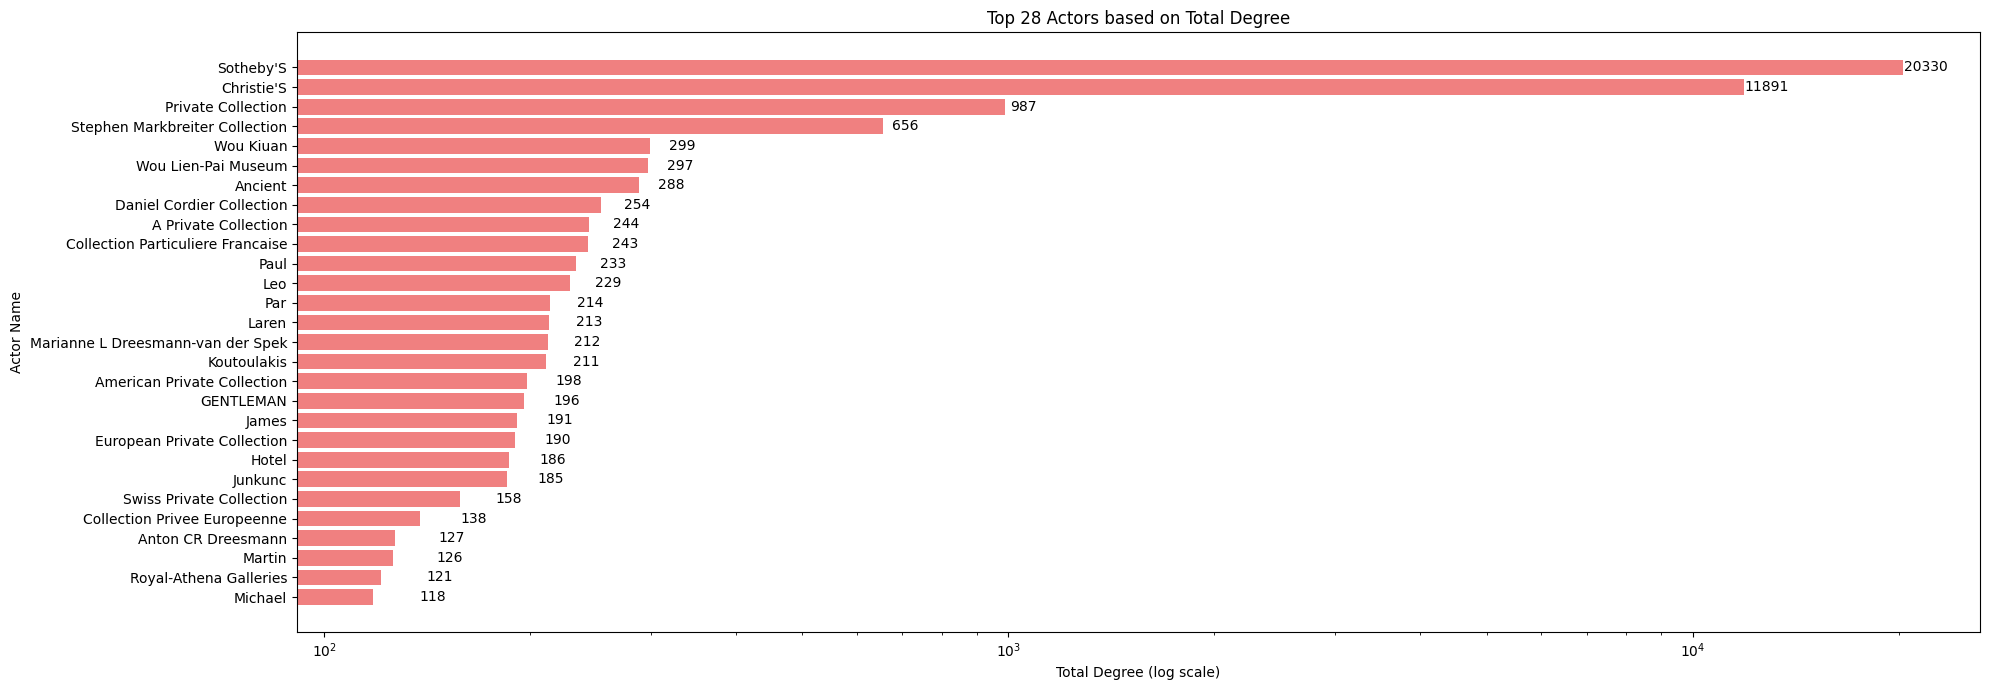

In [100]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Calculate total degree for each actor node
actor_degrees = {node: subgraph.degree(node) for node in subgraph.nodes() if subgraph.nodes[node]['label'] == 'actor'}

# Sort nodes by total degree in descending order
sorted_nodes = sorted(actor_degrees, key=actor_degrees.get, reverse=True)

# Choose the top 28 nodes (actors with highest total degree)
top_nodes = sorted_nodes[:28]
for node in top_nodes:
    print(node)
    

# Get names and total degree values for the top nodes
node_names = [subgraph.nodes[node]['properties']['name'] for node in top_nodes]
node_total_degrees = [actor_degrees[node] for node in top_nodes]

# Create a bar plot with logarithmic scale
plt.figure(figsize=(20, 7))  # Adjust the figure size for a 2:1 ratio
bars = plt.barh(node_names, node_total_degrees, color='lightcoral')  # Use a light coral color
plt.xscale('log')  # Set x-axis to logarithmic scale
plt.xlabel('Total Degree (log scale)')
plt.ylabel('Actor Name')
plt.title('Top 28 Actors based on Total Degree')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest degree at the top

# Display total degree values inside the bars
for i, bar in enumerate(bars):
    plt.text(bar.get_width() +20, bar.get_y() + bar.get_height()/2, f'{node_total_degrees[i]}', va='center')
# Adjust margins to prevent text from going outside the figure boundary
plt.subplots_adjust(left=0.2, right=15)

# Create 'plots' directory if it doesn't exist
os.makedirs('plots', exist_ok=True)

plt.tight_layout()  # Adjust layout for better appearance
plt.savefig('plots/total_degree_plot.png', dpi=300, bbox_inches='tight')  # Save the plot to a file
plt.show()




<h3>Second Projection: from bipartite to a one-mode undirected weighted graph (actors)-[:SHARES_ARTWORK]-(actors)</h3>

The following cell will operate the projection directly in python, but it takes a long time

In [166]:
import networkx as nx
from tqdm.notebook import tqdm
import community
import networkx as nx

# Create a new directed graph to hold the adjusted edges
adjusted_graph = nx.DiGraph()
# Sort nodes by degree in descending order
sorted_nodes = sorted(subgraph.nodes(), key=lambda x: subgraph.degree(x), reverse=True)

# Create a new undirected subgraph for actor sharing artwork
shared_artwork_subgraph = nx.Graph()

# Create a subgraph excluding the highest degree nodes "Christie's" and "Sotheby's"
subgraph_excluded = subgraph.subgraph(sorted_nodes[2:])
# Iterate through the 'actor' nodes in the original subgraph
for actor in tqdm(subgraph_excluded.nodes(),desc='Processing nodes'):
    if subgraph.nodes[actor]['label'] == 'actor':
        # Get the 'artwork' neighbors of the current 'actor'
        actor_neighbors = [neighbor for neighbor in subgraph_excluded.neighbors(actor) if subgraph_excluded.nodes[neighbor]['label'] == 'artwork']
        # Create edges between the 'actor' and 'artwork' neighbors
        for artwork in actor_neighbors:
            shared_actors = [neighbor for neighbor in subgraph_excluded.neighbors(artwork) if neighbor != actor and subgraph_excluded.nodes[neighbor]['label'] == 'actor']
            for shared_actor in shared_actors:
                # Add the start node as 'actor' and the end node as 'actor' in the adjusted graph
                adjusted_graph.add_node(actor, **subgraph_excluded.nodes[actor])
                adjusted_graph.add_node(shared_actor, **subgraph_excluded.nodes[shared_actor])
                # Add the edge between actors with weight based on the number of shared artworks
                shared_artworks_count = len([neighbor for neighbor in subgraph_excluded.neighbors(artwork) if subgraph_excluded.nodes[neighbor]['label'] == 'actor'])
                adjusted_graph.add_edge(actor, shared_actor, weight=shared_artworks_count)

# Convert the directed graph to an undirected graph
adjusted_graph = adjusted_graph.to_undirected()

# Find all connected components in the undirected graph
connected_components = list(nx.connected_components(adjusted_graph))

# Find the largest connected component
largest_connected_component = max(connected_components, key=len)
print(len(largest_connected_component))

# Create a subgraph containing only the largest connected component
largest_subgraph = adjusted_graph.subgraph(largest_connected_component)
adjusted_graph = largest_subgraph

Processing nodes:   0%|          | 0/16493 [00:00<?, ?it/s]

4205


In [167]:
from py2neo import Graph, Node, Relationship
import networkx as nx
import threading
import time
from tqdm.notebook import tqdm

# Number of Nodes
num_nodes = largest_subgraph.number_of_nodes()
print("Number of Nodes:", num_nodes)

# Number of Relationships (edges)
num_edges = largest_subgraph.number_of_edges()
print("Number of Relationships:", num_edges)

# Average Degree
avg_degree = sum(dict(largest_subgraph.degree()).values()) / num_nodes
print("Average Degree (AD):", avg_degree)


# Create a lock to prevent concurrent access
#lock = threading.Lock()


def calculate_with_timeout(func, graph, timeout):
    result = None

    def calculation_thread():
        nonlocal result
        try:
            result = func(graph)
        except Exception as e:
            result = "Calculation error: " + str(e)

    thread = threading.Thread(target=calculation_thread)
    thread.start()
    thread.join(timeout)
    
    if thread.is_alive():
        thread.join()  # Make sure the thread is terminated
        result = "Calculation took too long and was terminated."

    return result
'''
# Calculate Average Path Length with timeout
avg_path_length = calculate_with_timeout(nx.average_shortest_path_length, largest_subgraph, timeout=20)
print("Average Path Length (L):", avg_path_length)

# Calculate Average Clustering Coefficient with timeout
avg_clustering = calculate_with_timeout(nx.average_clustering, largest_subgraph, timeout=20)
print("Average Clustering Coefficient (C):", avg_clustering)

# Calculate Graph Edge Density with timeout
graph_density = calculate_with_timeout(nx.density, largest_subgraph, timeout=20)
print("Graph Edge Density (Dns):", graph_density)

# Calculate Graph Diameter with timeout
graph_diameter = calculate_with_timeout(nx.diameter, largest_subgraph, timeout=20)
print("Graph Diameter:", graph_diameter)
'''

Number of Nodes: 4205
Number of Relationships: 31826
Average Degree (AD): 15.137217598097504


'\n# Calculate Average Path Length with timeout\navg_path_length = calculate_with_timeout(nx.average_shortest_path_length, largest_subgraph, timeout=20)\nprint("Average Path Length (L):", avg_path_length)\n\n# Calculate Average Clustering Coefficient with timeout\navg_clustering = calculate_with_timeout(nx.average_clustering, largest_subgraph, timeout=20)\nprint("Average Clustering Coefficient (C):", avg_clustering)\n\n# Calculate Graph Edge Density with timeout\ngraph_density = calculate_with_timeout(nx.density, largest_subgraph, timeout=20)\nprint("Graph Edge Density (Dns):", graph_density)\n\n# Calculate Graph Diameter with timeout\ngraph_diameter = calculate_with_timeout(nx.diameter, largest_subgraph, timeout=20)\nprint("Graph Diameter:", graph_diameter)\n'

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

# Your adjusted_graph
adjusted_graph = largest_subgraph

# Calculate centrality measures
degree_centrality = nx.degree_centrality(adjusted_graph)
betweenness_centrality = nx.betweenness_centrality(adjusted_graph)
closeness_centrality = nx.closeness_centrality(adjusted_graph)
eigenvector_centrality = nx.eigenvector_centrality(adjusted_graph)

# Get centrality values for each node
degree_values = np.array([degree_centrality[node] for node in adjusted_graph.nodes()])
betweenness_values = np.array([betweenness_centrality[node] for node in adjusted_graph.nodes()])
closeness_values = np.array([closeness_centrality[node] for node in adjusted_graph.nodes()])
eigenvector_values = np.array([eigenvector_centrality[node] for node in adjusted_graph.nodes()])



In [177]:
print(f'Degree Centrality {sum(degree_centrality.values())}')
print(f'Eigenvector Centrality {sum(eigenvector_centrality.values())}')
print(f'Betweenness Centrality {sum(betweenness_centrality.values())}')
print(f'Closeness Centrality {sum(closeness_centrality.values())}')

Degree Centrality 15.140818268316105
Eigenvector Centrality 11.373184178377965
Betweenness Centrality 2.6527360389808106
Closeness Centrality 1174.9431861972698


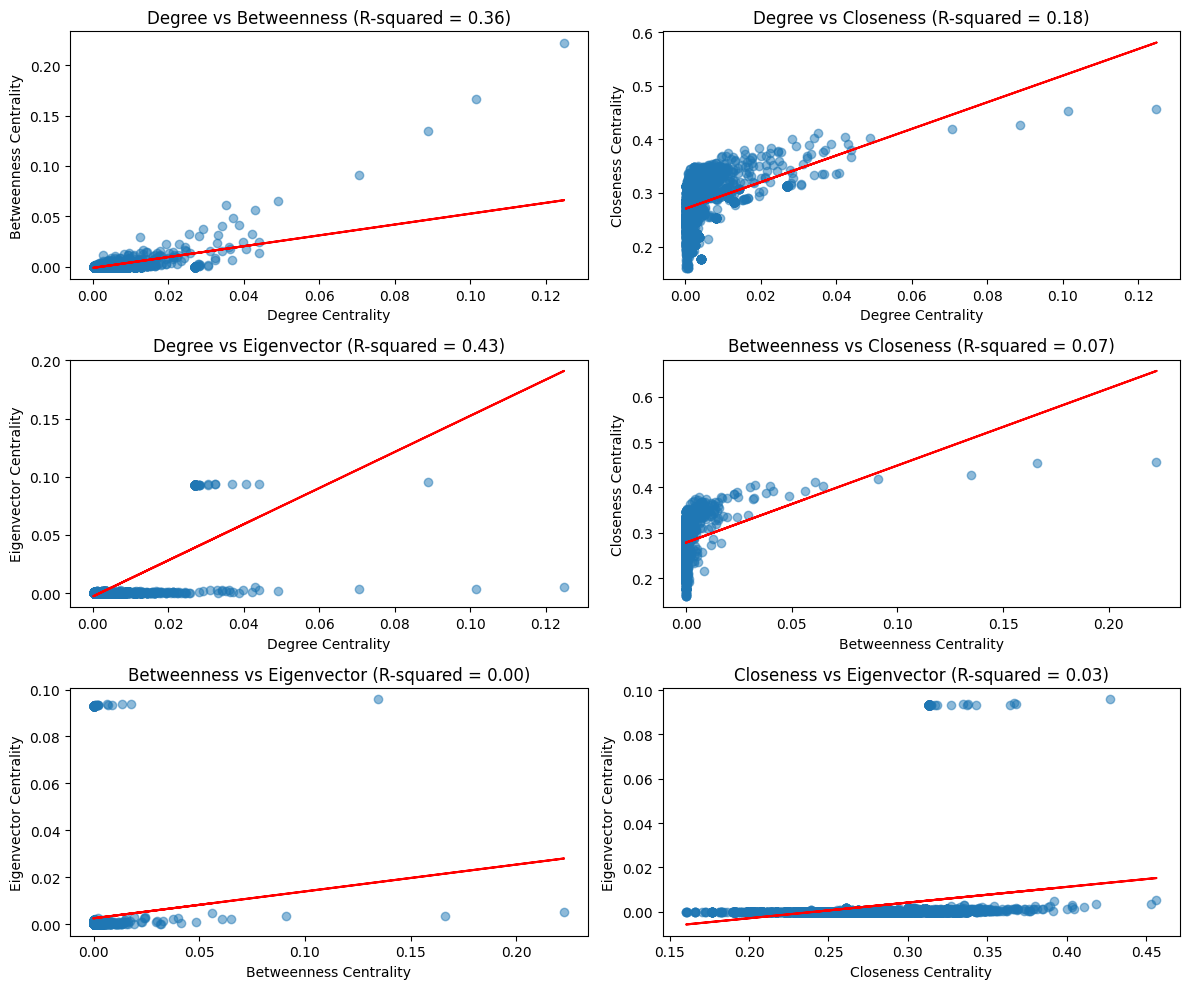

In [172]:
# Create scatter plots
plt.figure(figsize=(12, 10))

# Degree vs Betweenness
plt.subplot(321)
plt.scatter(degree_values, betweenness_values, alpha=0.5)
plt.xlabel("Degree Centrality")
plt.ylabel("Betweenness Centrality")
slope, intercept, r_value, p_value, std_err = linregress(degree_values, betweenness_values)
plt.plot(degree_values, slope * degree_values + intercept, color='red')
plt.title(f"Degree vs Betweenness (R-squared = {r_value ** 2:.2f})")

# Degree vs Closeness
plt.subplot(322)
plt.scatter(degree_values, closeness_values, alpha=0.5)
plt.xlabel("Degree Centrality")
plt.ylabel("Closeness Centrality")
slope, intercept, r_value, p_value, std_err = linregress(degree_values, closeness_values)
plt.plot(degree_values, slope * degree_values + intercept, color='red')
plt.title(f"Degree vs Closeness (R-squared = {r_value ** 2:.2f})")

# Degree vs Eigenvector
plt.subplot(323)
plt.scatter(degree_values, eigenvector_values, alpha=0.5)
plt.xlabel("Degree Centrality")
plt.ylabel("Eigenvector Centrality")
slope, intercept, r_value, p_value, std_err = linregress(degree_values, eigenvector_values)
plt.plot(degree_values, slope * degree_values + intercept, color='red')
plt.title(f"Degree vs Eigenvector (R-squared = {r_value ** 2:.2f})")

# Betweenness vs Closeness
plt.subplot(324)
plt.scatter(betweenness_values, closeness_values, alpha=0.5)
plt.xlabel("Betweenness Centrality")
plt.ylabel("Closeness Centrality")
slope, intercept, r_value, p_value, std_err = linregress(betweenness_values, closeness_values)
plt.plot(betweenness_values, slope * betweenness_values + intercept, color='red')
plt.title(f"Betweenness vs Closeness (R-squared = {r_value ** 2:.2f})")

# Betweenness vs Eigenvector
plt.subplot(325)
plt.scatter(betweenness_values, eigenvector_values, alpha=0.5)
plt.xlabel("Betweenness Centrality")
plt.ylabel("Eigenvector Centrality")
slope, intercept, r_value, p_value, std_err = linregress(betweenness_values, eigenvector_values)
plt.plot(betweenness_values, slope * betweenness_values + intercept, color='red')
plt.title(f"Betweenness vs Eigenvector (R-squared = {r_value ** 2:.2f})")

# Closeness vs Eigenvector
plt.subplot(326)
plt.scatter(closeness_values, eigenvector_values, alpha=0.5)
plt.xlabel("Closeness Centrality")
plt.ylabel("Eigenvector Centrality")
slope, intercept, r_value, p_value, std_err = linregress(closeness_values, eigenvector_values)
plt.plot(closeness_values, slope * closeness_values + intercept, color='red')
plt.title(f"Closeness vs Eigenvector (R-squared = {r_value ** 2:.2f})")

plt.tight_layout()
plt.show()


15.140818268316105

In [178]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
import pandas as pd

# Create a function to print the top nodes based on centrality values
def print_top_nodes(centrality_dict, centrality_name, num_top_nodes=50):
    sorted_nodes = sorted(centrality_dict, key=centrality_dict.get, reverse=True)
    top_nodes = sorted_nodes[:num_top_nodes]
    
    print(f"Top {num_top_nodes} nodes based on {centrality_name} centrality:")
    print("{:<10} {:<30} {:<20}".format("Node", "Centrality Value", "Label"))
    print("="*60)
    for node in top_nodes:
        centrality_value = centrality_dict[node]
        node_label = adjusted_graph.nodes[node]['properties']['name']
        print("{:<10} {:<30} {:<20}".format(node, centrality_value, node_label))

# Print top nodes based on centrality measures
print_top_nodes(eigenvector_centrality, "Eigenvector", num_top_nodes=50)
print("\n")
print_top_nodes(betweenness_centrality, "Betweenness", num_top_nodes=50)
print("\n")
print_top_nodes(closeness_centrality, "Closeness", num_top_nodes=50)
print('\n')
print_top_nodes(degree_centrality, "Degree", num_top_nodes=50)

Top 50 nodes based on Eigenvector centrality:
Node       Centrality Value               Label               
James      0.09584687932707835            James               
39080      0.09401659348778503            Oxford              
41534      0.09387125418991807            Alexander           
38484      0.09366910121304592            Apollo              
42112      0.0935737526872083             William             
42546      0.09346590070220465            Nicholas            
40490      0.09339699149351915            The Manor House     
44581      0.09329530666676213            David Cecil         
44075      0.09324550168723088            Denys Sutton        
42473      0.09322504867569799            Chamberlain         
David Jones 0.09322298966742691            David Jones         
40019      0.09321939640871396            Albert Museum       
43339      0.09319143408969353            Anthony             
44601      0.09316902671537335            Berners             
44576   

In [197]:
ego_network = nx.ego_graph(adjusted_graph, 38570, radius=2)

# Draw the ego network
pos = nx.spring_layout(ego_network, seed=42)  # Layout for visualization


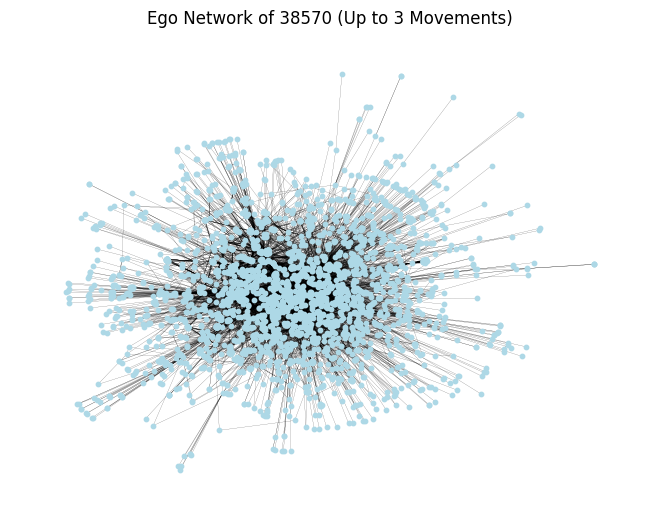

In [198]:
nx.draw(ego_network, pos, with_labels=False, node_size=10, node_color='lightblue', font_size=10, width=0.1)
plt.title(f"Ego Network of {central_node} (Up to 3 Movements)")
plt.show()

In [193]:
import networkx as nx
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

def displayEgo(central_node,graph,radius=2,size=10,thickness=15,width=0.5,color="#888"):   
    
    # Create the ego network up to 3 movements
    ego_network = nx.ego_graph(graph, central_node, radius=radius)
    
    # Create a Plotly figure
    fig = make_subplots(rows=1, cols=1)
    
    # Create a list of hover text for nodes (customize this based on your node properties)
    hover_text = [f"Node: {node}<br>Property: {adjusted_graph.nodes[node].get('property', 'N/A')}" for node in ego_network.nodes()]
    
    # Create a scatter plot of nodes
    node_trace = go.Scatter(
        x=[],
        y=[],
        mode="markers",
        text=hover_text,
        hoverinfo="text",
        marker=dict(
            showscale=True,
            colorscale="Viridis",
            size=size,
            colorbar=dict(
                thickness=thickness,
                title="Node Connections",
                xanchor="left",
                titleside="right",
            ),
        ),
    )
    
    # Add nodes to the Plotly figure
    for node in ego_network.nodes():
        x, y = np.random.rand(2)  # Adjust the positions as needed
        node_trace["x"] += tuple([x])
        node_trace["y"] += tuple([y])
    
    # Create edges
    edge_trace = go.Scatter(
        x=[],
        y=[],
        line=dict(width=width, color=color),
        hoverinfo="none",
        mode="lines",
    )
    
    # Add edges to the Plotly figure
    for edge in ego_network.edges():
        x0, y0 = node_trace["x"][list(ego_network.nodes()).index(edge[0])], node_trace["y"][list(ego_network.nodes()).index(edge[0])]
        x1, y1 = node_trace["x"][list(ego_network.nodes()).index(edge[1])], node_trace["y"][list(ego_network.nodes()).index(edge[1])]
        edge_trace["x"] += tuple([x0, x1, None])
        edge_trace["y"] += tuple([y0, y1, None])
    
    fig.add_trace(node_trace)
    fig.add_trace(edge_trace)
    
    # Configure the layout
    fig.update_layout(
        showlegend=False,
        hovermode="closest",
        title=f"Ego Network of {central_node} (Up to 3 Movements)",
    )
    
    # Display the interactive plot in Jupyter Lab
    fig.show()
    




In [195]:
displayEgo(38570,adjusted_graph)

KeyboardInterrupt: 